# Example 6a: Silicon HIT cell

In [Example 4a](4a-textured_Si_cell.ipynb), we looked at a solar cell made of a single layer of Si with pyramidal texturing. In reality, a
solar cell will have a more complicated structure with thin layers deposited on the front side to act as e.g. selective
transport layers for carriers. This adds a layer of complication to the ray-tracing process, because we can no longer
rely on the Fresnel equations to calculate the angle and wavelength-dependent reflection and transmission probabilities;
we might get absorption in the surface layers, and we need to take into account interference in the surface layers.
To do this, we can combine ray-tracing and the transfer-matrix method; we can calculate the reflection, absorption and
transmission probabilities using TMM, and use those probabilities in our ray-tracing calculations. In RayFlare, this
functionality is implemented as part of the angular redistribution matrix functionality.

This example is (loosely) based on the simulations done for [this paper](https://doi.org/10.1016/j.solmat.2019.110051) which looks at the absorptivity/emissivity of silicon
heterojunction (HJT or HIT) cells, although here we will only look at the usual wavelengths for the photovoltaic operation of silicon solar cells rather than the infrared.

In [16]:
from solcore import material, si
from solcore.light_source import LightSource
from solcore.constants import q
from solcore.solar_cell import SolarCell, Layer, Junction
from solcore.solar_cell_solver import default_options as defaults_solcore, solar_cell_solver

from rayflare.textures import regular_pyramids
from rayflare.structure import Interface, BulkLayer, Structure
from rayflare.matrix_formalism import calculate_RAT, process_structure
from rayflare.options import default_options
from rayflare.utilities import make_absorption_function

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter1d

from cycler import cycler

## Setting up

We add some new materials to Solcore's database from data files - you only need to add these once, after that you can comment these lines out.

In [1]:
from solcore.material_system import create_new_material

create_new_material('aSi_i', os.path.join("data", "model_i_a_silicon_n.txt"),
                    os.path.join("data", "model_i_a_silicon_k.txt"))
create_new_material('ITO_measured', os.path.join("data", "front_ITO_n.txt"),
                    os.path.join("data", "front_ITO_k.txt"))

SyntaxError: invalid syntax (2638323969.py, line 3)

Setting user options. Several of these (wavelength, number of rays, `nx`, `ny`) have been encountered in previous examples. However, because we are using the angular redistribution matrix method for the first time, there are some new ones. Please see RayFlare's [documentation](https://rayflare.readthedocs.io/en/latest/Options/user_options.html) for more detailed information.

- `project_name`: When we run the simulation, we will generate large matrices which will eventually be multiplied together. These have to be stored somewhere. This is the name of the folder where they will be stored.
- `n_theta_bins`: The number of polar angle bins to divide the hemisphere into when calculating the redistribution matrices.
- `I_thresh`: Threshold intensity at which to stop matrix multiplication (i.e. when almost all the light has been reflected, transmitted or absorbed)
- `bulk_profile`: True or False; whether to calculate the absorption profile in the bulk material (Si in this case).

In [18]:
wavelengths = np.linspace(300, 1200, 80)*1e-9

options = default_options()
options.wavelengths = wavelengths
options.project_name = 'HIT_example'
options.n_rays = 10000 # Reduce this (or the number of wavelengths) to speed up the example! Note that this is the TOTAL number of rays (all angle bins) per wavelength
options.n_theta_bins = 20
options.nx = 5
options.ny = 5
options.I_thresh = 0.005
options.bulk_profile = True

We now define the materials and layer structures for the front and rear surfaces. In this case, the front and rear layers are the materials which will be deposited on top of the pyramids (amorphous silicon and ITO); the crystalline silicon itself will be the bulk material which connects the two interfaces.

In [19]:
Si = material('Si')()
Air = material('Air')()
ITO = material('ITO_measured')()

Ag = material('Ag')()
aSi = material('aSi_i')()

front_materials = [Layer(80e-9, ITO), Layer(13e-9, aSi)]
back_materials = [Layer(13e-9, aSi), Layer(240e-9, ITO)]

Now we define the front and rear surfaces using the `Interface` class. Whether pyramids are upright or inverted is relative to front incidence, so if the same etch is applied to both sides of a slab of silicon, one surface will have 'upright' pyramids and the other side will have 'not upright' (inverted) pyramids in the model. The arguments required for `Interface` depend on the optical method which is being used; in this case, we must provide the surface texture, layer stack, and whether the layers are to be treated coherently (i.e. affected by thin-film interference). We also have to give the surfaces a name; as with the project name, this is to store the matrices which will be calculated.

In [20]:
surf = regular_pyramids(elevation_angle=55, upright=True) # elevation angle is relative to horizontal plane
surf_back = regular_pyramids(elevation_angle=55, upright=False)

front_surf = Interface('RT_TMM', texture=surf, layers=front_materials, name='HIT_front', coherent=True)
back_surf = Interface('RT_TMM', texture=surf_back, layers=back_materials, name='HIT_back', coherent=True)

bulk_Si = BulkLayer(170e-6, Si, name='Si_bulk') # bulk thickness in m

Finally, we build the whole structure inside RayFlare's `Structure` class, also specifying the incidence medium (above the cell) and the transmission medium (below the cell).

In [21]:
SC = Structure([front_surf, bulk_Si, back_surf], incidence=Air, transmission=Ag)

## Generating results

Now we are ready to start running calculations. This happens in two phases:

1. Call `process_structure` to check each surface in the structure, and generate angular redistribution matrices (if it does not find existing ones)
2. Call `calculate_rat` to run the matrix multiplication and generate reflection, transmission and absorption results

In [22]:
process_structure(SC, options, save_location="current")
# save_location = current means that the folder with the redistribution matrix will be created in the current working directory. By default, it is saved in a folder called
# RayFlare_results in your home directory (~).
results = calculate_RAT(SC, options, save_location="current")

Making lookuptable for element 0 in structure
Making lookuptable for element 2 in structure
Ray tracing with TMM lookup table for element 0 in structure
Calculating matrix only for incidence theta/phi
Ray tracing with TMM lookup table for element 2 in structure
After iteration 1 : maximum power fraction remaining = 0.5629448135186488
After iteration 2 : maximum power fraction remaining = 0.3425270607560974
After iteration 3 : maximum power fraction remaining = 0.20990358983841642
After iteration 4 : maximum power fraction remaining = 0.12862942930538473
After iteration 5 : maximum power fraction remaining = 0.0788271578176077
After iteration 6 : maximum power fraction remaining = 0.04832164906096151
After iteration 7 : maximum power fraction remaining = 0.029625034965812196
After iteration 8 : maximum power fraction remaining = 0.018162348111822744
After iteration 9 : maximum power fraction remaining = 0.011134523091393584
After iteration 10 : maximum power fraction remaining = 0.00682

The structure of the results returned by calculate_RAT is quite complicated; it is explained on [this page](https://rayflare.readthedocs.io/en/latest/Matrix/matrix_method.html).

In [23]:
RAT = results[0]
results_per_pass = results[1]

R_per_pass = np.sum(results_per_pass['r'][0], axis=2)
R_0 = R_per_pass[0]
R_escape = np.sum(R_per_pass[1:, :], axis=0)

# results_per_pass: sum over passes to get overall absorption in each layer.
results_per_layer_front = np.sum(results_per_pass['a'][0], axis=0)

results_per_layer_back = np.sum(results_per_pass['a'][1], axis=0)

To get the maximum current we could achieve based on these optical results, we calculate the photogenerated current using the AM1.5G spectrum.

In [24]:
spectr_flux = LightSource(source_type='standard', version='AM1.5g', x=wavelengths,
                           output_units='photon_flux_per_m', concentration=1).spectrum(wavelengths)[1]

Jph_Si = q * np.trapz(RAT['A_bulk'][0] * spectr_flux, wavelengths)/10 # mA/cm2

print("Photogenerated current in Si = %.1f mA/cm2" % Jph_Si)

Photogenerated current in Si = 37.5 mA/cm2


## Plotting

Now, we plot where all incident light goes: reflection, absorption in each layer, and transmission into the substrate in the simulation. Note that we set the substrate as Ag for the simulation; although in the actual device the Ag is not infinitely thick, in practice it is thick enough that all light which enters the Ag will be absorbed there so we can treat is as the final material.

**PLOT 1**: Reflection and absorption in the Si HIT cell

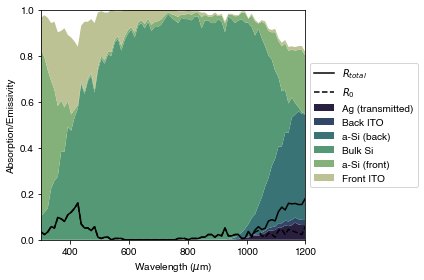

In [25]:
# Stack results for plotting
allres = np.hstack((RAT['T'].T, results_per_layer_back,
                    RAT['A_bulk'].T, results_per_layer_front)).T

# Create colors for plotting
pal = sns.cubehelix_palette(allres.shape[0] + 1, start=.5, rot=-.9)
pal.reverse()

# Update default colours used by matplotlib
cols = cycler('color', pal)
params = {'axes.prop_cycle': cols}
plt.rcParams.update(params)

# plot total R, A, T
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.plot(options['wavelengths']*1e9, R_escape + R_0, '-k', label=r'$R_{total}$')
ax.plot(options['wavelengths']*1e9, R_0, '--k', label=r'$R_0$')
ax.stackplot(options['wavelengths']*1e9, allres,
             labels=['Ag (transmitted)', 'Back ITO', 'a-Si (back)', 'Bulk Si',
                     'a-Si (front)', 'Front ITO'
                     ])
ax.set_xlabel(r'Wavelength ($\mu$m)')
ax.set_ylabel('Absorption/Emissivity')
ax.set_xlim(min(options['wavelengths']*1e9), max(options['wavelengths']*1e9))
ax.set_ylim(0, 1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

We see that over this wavelength range, most of the absorption happens in the bulk Si, as expected. However, at short wavelengths we see significant absorption in the front surface layers, and at long wavelengths we see absorption in the back layers and Ag. We have plotted both the total reflection $R_{total}$ and $R_0$, which is the light which is lost due to initial reflection at the front surface. Up to around 1000 nm, these lines coincide (total reflection is entirely due to initial front surface reflection). At longer wavelengths, we see that $R_0$ is lower than $R_{total}$, as now a significant fraction of the total reflection is from light which enters the cell, makes at least one full forward and backward pass, and then leaves the cell through the front surface. This becomes significant close to the bandgap as the Si becomes transparent.

In the plot above we see stochastic noise due to the ray-tracing simulation; we could increase the number of rays to reduce this, which also increases the computation time. Below, we re-plot the same data with some smoothing.

**PLOT 2**: Reflection and absorption in the Si HIT cell, with smoothed data

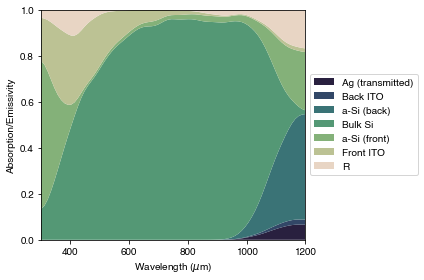

In [26]:
ysmoothed = gaussian_filter1d(np.vstack((allres, RAT["R"])), sigma=2, axis=1)

# plot total R, A, T - smoothed
fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.stackplot(options['wavelengths']*1e9, ysmoothed,
             labels=['Ag (transmitted)', 'Back ITO', 'a-Si (back)', 'Bulk Si',
                     'a-Si (front)', 'Front ITO', 'R'
                     ])
ax.set_xlabel(r'Wavelength ($\mu$m)')
ax.set_ylabel('Absorption/Emissivity')
ax.set_xlim(min(options['wavelengths']*1e9), max(options['wavelengths']*1e9))
ax.set_ylim(0, 1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## Device simulations

As we did in [Example 4a](4a-textured_Si_cell.ipynb), we can now feed the results from RayFlare's optical calculation into Solcore to run electrical simulations. We generate the absorption profile function, then specify materials and layers for the solar cell structure.

In [27]:
profile_Si = results[3][0]
external_R = RAT['R'][0, :]

positions, absorb_fn = make_absorption_function([None, profile_Si, None], SC, options, matrix_method=True)

Si_SC = material("Si")
GaAs_SC = material("GaAs")
T = 300

p_material_Si = Si_SC(T=T, Na=si(1e21, "cm-3"), electron_diffusion_length=si("10um"), hole_mobility=50e-4)
n_material_Si = Si_SC(T=T, Nd=si(1e16, "cm-3"), hole_diffusion_length=si("290um"), electron_mobility=400e-4)

As we noted in [Example 4a](4a-textured_Si_cell.ipynb), we need to specify the user options for Solcore separately (though they should of course be consistent with the options we gave RayFlare above, where relevant!). We set options, create the solar cell structure, and run QE and IV calculations:

In [28]:
#| output: false

options_sc = defaults_solcore
options_sc.optics_method = "external"
options_sc.position = positions
options_sc.light_iv = True
options_sc.wavelength = wavelengths
options_sc.mpp = True
options_sc.theta = options.theta_in*180/np.pi
V = np.linspace(0, 2.5, 250)
options_sc.voltages = V

solar_cell = SolarCell([Layer(80e-9, ITO),
                   Layer(13e-9, aSi),
                   Junction([Layer(500e-9, p_material_Si, role="emitter"),
                             Layer(bulk_Si.width-500e-9, n_material_Si, role="base")], kind="DA"),
                   Layer(13e-9, aSi),
                   Layer(240e-9, ITO)],
                  external_reflected = external_R,
                                       external_absorbed = absorb_fn)



solar_cell_solver(solar_cell, 'qe', options_sc)
solar_cell_solver(solar_cell, 'iv', options_sc)

Solving optics of the solar cell...
Solving QE of the solar cell...
Solving optics of the solar cell...
Already calculated reflection, transmission and absorption profile - not recalculating. Set recalculate_absorption to True in the options if you want absorption to be calculated again.
Solving IV of the junctions...
Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


Now we can plot the results. To check things are consistent, we will plot the total absorption in Si calculated above with RayFlare, and `solar_cell.absorbed`, which is the result Solcore gives for total absorption. We also plot the EQE, which should be the same as or lower than the absorption.

**PLOT 3**: Absorption in the Si and EQE.

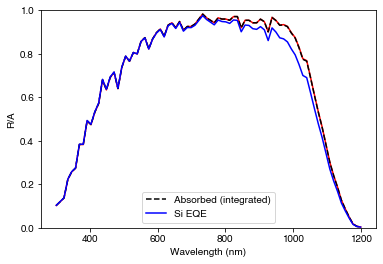

In [29]:
plt.figure()
plt.plot(options['wavelengths']*1e9, RAT["A_bulk"][0], 'r-')
plt.plot(wavelengths*1e9, solar_cell.absorbed, 'k--', label='Absorbed (integrated)')
plt.plot(wavelengths*1e9, solar_cell[2].eqe(wavelengths), 'b-', label='Si EQE')
plt.ylim(0,1)
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel('R/A')
plt.show()

**PLOT 4**: Current-voltage behaviour of the Si cell under illumination

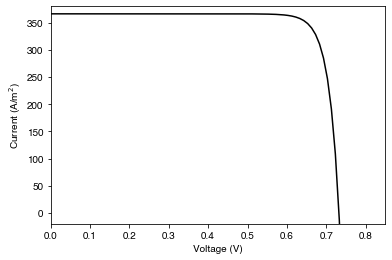

In [30]:
plt.figure()
plt.plot(V, solar_cell.iv['IV'][1], '-k')
plt.ylim(-20, 380)
plt.xlim(0, 0.85)
plt.ylabel('Current (A/m$^2$)')
plt.xlabel('Voltage (V)')
plt.show()